In [46]:
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from tqdm.notebook import trange

In [47]:
from src.box import GravityHoleBall
from src.utils import add_spatial_encoding, gaussian_density
from src.models import ConvAE
from src.viz import plot_tsne_and_pca, plot_tsne_and_pca_portrait
from src.ode import ODEnetSimple, train

In [48]:
MARGIN = 5
MARGIN_MIN = 4
WIDTH, HEIGHT = 28, 28
RADIUS = 3

In [49]:
x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)

In [50]:
def generate_gravity_hole_ball_data(box, N, N_frames, dt):
    dataset = []

    INDICES_MATRIX = np.array([[i,j] for i in range(WIDTH) for j in range(HEIGHT)])

    for _ in trange(N):
        x = np.random.uniform(MARGIN, WIDTH - MARGIN)
        y = np.random.uniform(MARGIN, HEIGHT - MARGIN)
        # # x**2 + y**2 < (width-margin)**2
        while (x - box.gravity_position[0])**2 + (y - box.gravity_position[1])**2 > (WIDTH-MARGIN)**2 or \
            (x - box.gravity_position[0])**2 + (y - box.gravity_position[1])**2 < (MARGIN_MIN)**2:
            x = np.random.uniform(MARGIN, WIDTH - MARGIN)
            y = np.random.uniform(MARGIN, HEIGHT - MARGIN)
        vx = 0.
        vy = 0.

        box.reset(x0=x, y0=y, vx0=vx, vy0=vy)
        trajectory = []

        x, y = box.move(0.)
        ball_img = gaussian_density(INDICES_MATRIX, np.array([x, y]), RADIUS).reshape(WIDTH, HEIGHT).numpy()
        ball_img = (ball_img - ball_img.min())/(ball_img.max() - ball_img.min())
        trajectory.append(ball_img)
        for _ in range(N_frames - 1):
            x, y = box.move(dt)
            ball_img = gaussian_density(INDICES_MATRIX, np.array([x, y]), RADIUS).reshape(WIDTH, HEIGHT).numpy()
            # normalize it
            ball_img = (ball_img - ball_img.min())/(ball_img.max() - ball_img.min())
            trajectory.append(ball_img.copy())

        dataset.append(trajectory)

    return np.array(dataset)

def generate_gravity_hole_ball_positions(box, N, N_frames, dt):
    dataset = []
    
    for _ in trange(N):
        x = np.random.uniform(MARGIN, WIDTH - MARGIN)
        y = np.random.uniform(MARGIN, HEIGHT - MARGIN)
        # # x**2 + y**2 < (width-margin)**2
        while (x - box.gravity_position[0])**2 + (y - box.gravity_position[1])**2 > (WIDTH-MARGIN)**2 or \
            (x - box.gravity_position[0])**2 + (y - box.gravity_position[1])**2 < (MARGIN_MIN)**2:
            x = np.random.uniform(MARGIN, WIDTH - MARGIN)
            y = np.random.uniform(MARGIN, HEIGHT - MARGIN)
        vx = 0.
        vy = 0.

        box.reset(x0=x, y0=y, vx0=vx, vy0=vy)
        trajectory = []

        x, y = box.move(0.)

        trajectory.append(( np.array([x, y]).copy() - np.array([WIDTH/2., HEIGHT/2.]))/np.array([WIDTH, HEIGHT]))
        for _ in range(N_frames - 1):
            x, y = box.move(dt)
            
            trajectory.append(( np.array([x, y]).copy() - np.array([WIDTH/2., HEIGHT/2.]))/np.array([WIDTH, HEIGHT]))

        dataset.append(trajectory)

    return np.array(dataset)


In [51]:
N = 1
N_frames = 300
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)

dataset = generate_gravity_hole_ball_data(box, N=N, N_frames=N_frames, dt=dt).reshape(-1, 1, HEIGHT, WIDTH)
print(dataset.shape)
dataset = [(image, 0) for image in dataset]
dataset = add_spatial_encoding(dataset)
print(len(dataset), len(dataset[0]))

  0%|          | 0/1 [00:00<?, ?it/s]

(300, 1, 28, 28)
300 2


In [52]:
# plt.imshow(dataset[1000][0][0], cmap='gray')

In [53]:
latent_dim = 3
# path = "models/AE/ae_1_Ball_with_sp_latent_{}.pth".format(latent_dim)
path = "models/AE/ae_1_Ball_with_sp_latent_{}_no_relu.pth".format(latent_dim)
ae = ConvAE(height=HEIGHT, width=WIDTH, in_channels=3, latent_dim=latent_dim, relu=False)
ae.load_state_dict(torch.load(path))

Number of parameters in the model: 225318


<All keys matched successfully>

In [54]:
images = torch.tensor([image for image, _ in dataset]).float()
print(images.shape)
encoded_trajectory = ae.encode(images).reshape(N, N_frames, latent_dim).detach()
print(encoded_trajectory.shape)

torch.Size([300, 3, 28, 28])
torch.Size([1, 300, 3])


In [55]:
# use the PCA and t-SNE to visualize the latent space
index = 0
pca = PCA(n_components=2)
pca_encoded_trajectory = pca.fit_transform(encoded_trajectory[index].detach().numpy())

tsne = TSNE(n_components=2, verbose=0)
tsne_encoded_trajectory = tsne.fit_transform(encoded_trajectory[index].detach().numpy())

/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


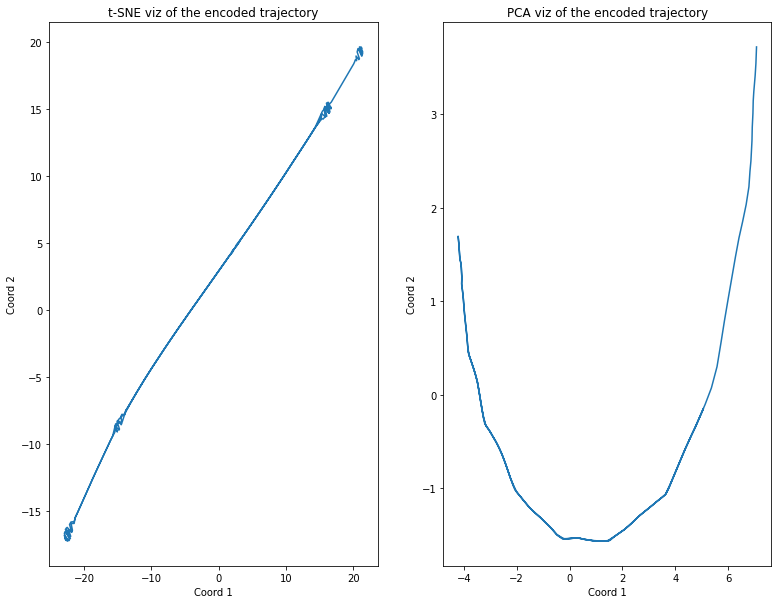

In [56]:
plot_tsne_and_pca(tsne_encoded_trajectory, pca_encoded_trajectory)

In [57]:
class BatchGetterMultiTrajectories:
    def __init__(self, batch_time, n_samples, total_length, dt, positions, frac_train):
        # N: number of trajectories
        # M: number of time steps
        # D: dimension of the state space
        # positions: (N, T, D)
        self.times = torch.linspace(0., total_length*dt, total_length, dtype=torch.float64).float()
        self.true_positions = torch.tensor(positions, dtype=torch.float64).float()
        self.N_train = int(positions.shape[0]*frac_train)

        self.train_times = self.times #[:self.N_train]
        self.test_times = self.times #[self.N_train:]
        self.train_positions = self.true_positions[:self.N_train]
        self.test_positions = self.true_positions[self.N_train:]
        self.n_samples = n_samples
        self.batch_time = batch_time
        self.dt = dt
        self.total_length = total_length

    def get_batch(self):
        index = 0 #np.random.randint(0, self.N_train, self.n_samples)
        s = torch.from_numpy(np.random.choice(np.arange(self.train_times.shape[0] - self.batch_time, dtype=np.int64), self.n_samples, replace=False))
        batch_y0 = self.train_positions[index, s]  # (M, D)
        batch_t = self.train_times[:self.batch_time]  # (T)
        batch_y = torch.stack([self.train_positions[index, s + i] for i in range(self.batch_time)], dim=0)  # (T, M, D)
        return batch_y0, batch_t, batch_y


In [58]:
latent_dim = 3
out_dim = latent_dim
mid_dim = [100, 100]
ode = ODEnetSimple(out_dim, mid_dim, out_dim)

Number of parameters: 10803


In [59]:
batch_time = 200
n_samples = 1
total_length = N_frames

getter = BatchGetterMultiTrajectories(batch_time, n_samples, total_length, dt, encoded_trajectory, frac_train=1.)

/var/folders/01/nfq6qhcj2j7dqfld6ps6vhbc0000gn/T/ipykernel_56558/2584834397.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.true_positions = torch.tensor(positions, dtype=torch.float64).float()


The graphs at epoch 0


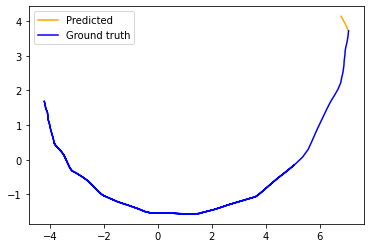

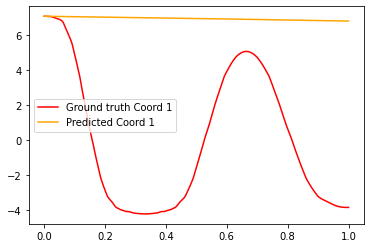

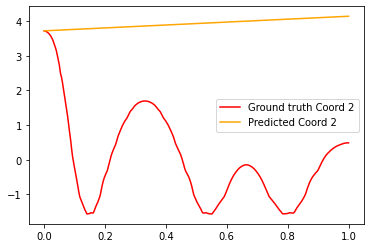

In [60]:

def display_results(i, model, getter, final_time, dt):

    print("The graphs at epoch {}".format(i))
    with torch.no_grad():
        index = 0 #np.random.randint(0, getter.N_train)

        times = torch.linspace(0., final_time*dt, final_time, dtype=torch.float64).float()

        y0, t, y = getter.get_batch()
        predicted_output = model(getter.train_positions[index, 0].unsqueeze(0), times)
        # display in orange the predicted position and in blue the true position of the training set
        
        pca = PCA(n_components=2).fit(getter.train_positions[index].numpy())
        pca_encoded_trajectory = pca.transform(predicted_output[:, -1].detach().numpy())
        # print(getter.train_positions[index].shape)
        pca_train_trajectory = pca.transform(getter.train_positions[index].numpy())

        plt.plot(pca_encoded_trajectory[:,0], 
                pca_encoded_trajectory[:,1], 'orange', label="Predicted")

        plt.plot(pca_train_trajectory[:,0], pca_train_trajectory[:,1], 'b', label="Ground truth")


        plt.legend()
        plt.show()

       

        # print the X axis over the time
        plt.plot(times, pca_train_trajectory[:,0], 'r', label="Ground truth Coord 1")
        plt.plot(times, pca_encoded_trajectory[:,0], 'orange', label="Predicted Coord 1")

        plt.legend()
        plt.show()

        plt.plot(times, pca_train_trajectory[:,1], 'r', label="Ground truth Coord 2")
        plt.plot(times, pca_encoded_trajectory[:,1], 'orange', label="Predicted Coord 2")
        
        
        # pca_encoded_trajectory = predicted_output[:, -1].detach().numpy()
        # pca_train_trajectory = getter.train_positions[index].numpy()
        # plt.plot(times, pca_train_trajectory[:], 'r', label="Ground truth Coord 1")
        # plt.plot(times, pca_encoded_trajectory[:], 'orange', label="Predicted Coord 1")
        plt.legend()
        plt.show()

display_results(0, ode, getter, final_time=N_frames, dt=dt)

In [19]:
optimizer = torch.optim.Adam(ode.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
batch_size = 1
epochs = 3000

  0%|          | 0/3000 [00:00<?, ?it/s]

The graphs at epoch 200


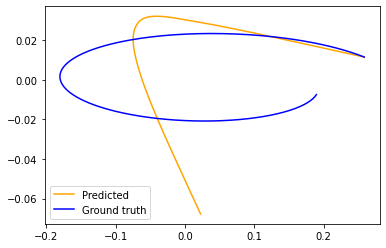

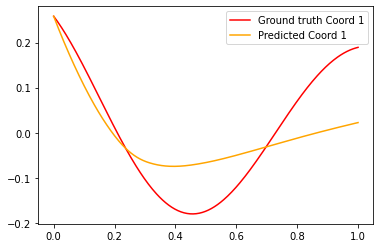

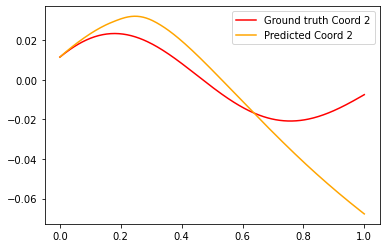

The graphs at epoch 400


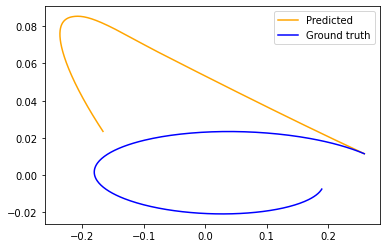

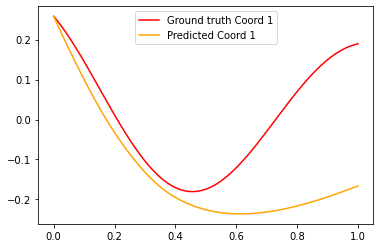

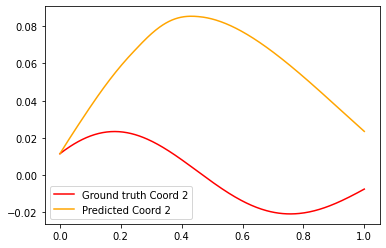

KeyboardInterrupt: 

In [23]:
train(ode, optimizer, scheduler, epochs, batch_size, getter, display=200, display_results_fn=display_results)

In [18]:
# save the ODE model
# torch.save(ode.state_dict(), 'models/AE_ODE/gravity_1_ball_{}_{}.pt'.format(latent_dim, mid_dim))

In [61]:
from src.anode import ANODENet

In [69]:
latent_dim = 3
device = "cpu"
data_dim = latent_dim
hidden_dim = 64
output_dim = latent_dim
augment_dim = 2
anode = ANODENet(device, data_dim, hidden_dim, output_dim, augment_dim, time_dependent=False)

In [70]:
batch_init_pos, batch_t, batch_y = getter.get_batch()
res = anode(batch_init_pos, batch_t)
print(res.shape, batch_t.shape)

torch.Size([200, 1, 3]) torch.Size([200])


In [77]:
optimizer = torch.optim.Adam(anode.parameters(), lr=3e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
batch_size = 1
epochs = 100000

  0%|          | 0/100000 [00:00<?, ?it/s]

The graphs at epoch 5000


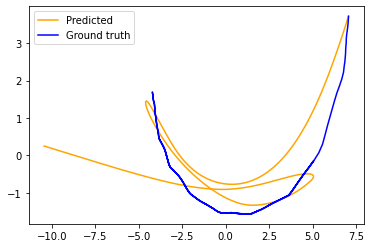

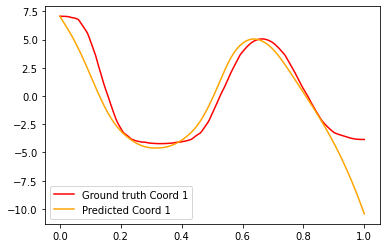

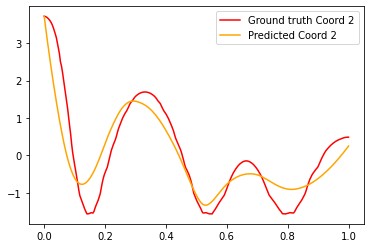

The graphs at epoch 10000


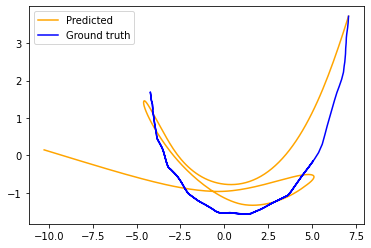

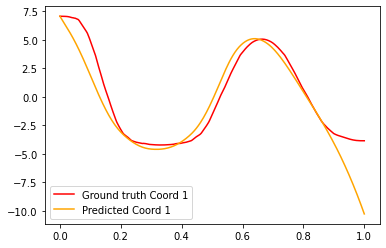

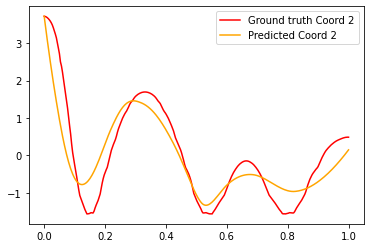

KeyboardInterrupt: 

In [78]:
train(anode, optimizer, scheduler, epochs, batch_size, getter, display=5000, display_results_fn=display_results)

In [79]:
# save the anode model
torch.save(anode.state_dict(), 'models/AE_ODE/anode_latent_gravity_1_ball_{}_{}_{}_more_gravity_and_friction.pt'.format(latent_dim, hidden_dim, augment_dim))

# save the trajectory used to train the anode
np.save('models/AE_ODE/trajectory_latent_gravity_1_ball_{}_{}_{}__more_gravity_and_friction.npy'.format(latent_dim, hidden_dim, augment_dim), getter.train_positions)

# save the images of the trajectory used to train the anode
np.save("models/AE_ODE/images_latent_gravity_1_ball__more_gravity_and_friction.npy" , np.array(images))